# Fraud Detection Explainability Agent

This notebook demonstrates a sophisticated fraud detection system that doesn't just predict risk but provides human-readable explanations. Using **LangGraph** for orchestration and **LLMs** for analysis, we transform raw transaction data and SHAP values into professional investigation reports.


In [1]:
import json
import joblib
import pandas as pd
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Dict, Any
import pandas as pd
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field
from enum import Enum
from rich import print
from scripts.utils import load_training_artifacts, transform_inference_data, predict_with_trained_model, explain_instance_shap_values, clean_data, generate_pdf
from datetime import datetime

c:\Users\SolaiVenkatesanManog\projects\kaggle\fraud-detection\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Setup and Environment

We begin by configuring the necessary API keys and importing local utility functions that handle data cleaning, model prediction, and PDF generation.


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

## 2. Data Loading and Preparation

We load sample inference data (both fraudulent and non-fraudulent examples) to test our explainability pipeline.


In [3]:
# Load the JSON file
with open(r"data/inference_data_fraud.json") as f:
    inference_json_fraud = json.load(f)

with open(r"data/inference_data_not_fraud.json") as f:
    inference_not_fraud = json.load(f)
inference_data = pd.DataFrame(inference_json_fraud)
inference_data_not_fraud = pd.DataFrame(inference_not_fraud)

## 3. Agent Architecture and State

The system is designed as a directed graph where each node represents a specific step in the analysis pipeline. The `FraudState` object tracks the data as it flows through these nodes.


In [4]:
class RiskLevel(str, Enum):
    """
    Enumeration defining standardized fraud risk classifications.

    This enum enforces consistency across:
        - Model interpretation
        - LLM narrative generation
        - Reporting outputs
        - Downstream operational workflows

    Risk levels must be selected strictly from these controlled values
    to ensure regulatory and reporting consistency.
    """

    LOW = "low"
    """Minimal fraud risk. Transaction aligns with expected behavioral patterns."""

    MEDIUM = "medium"
    """Moderate fraud risk. Transaction exhibits some anomalies requiring review."""

    HIGH = "high"
    """Elevated fraud risk. Transaction displays strong indicators of potential fraud."""


class InvestigationSummary(BaseModel):
    """
    Executive-level, non-technical overview of the fraud investigation outcome.

    This section is designed for:
        - Senior management
        - Risk committees
        - Compliance officers
        - External auditors

    It must remain:
        - Concise
        - Objective
        - Non-technical
        - Free of model jargon or algorithmic details

    The summary synthesizes analytical findings into business-level language.
    """

    summary: str = Field(
        description=(
            "Executive summary of the fraud investigation outcome. "
            "Must explain overall risk posture and primary drivers "
            "in approximately five sentences. Avoid technical ML terminology."
        )
    )

    risk_classification: RiskLevel = Field(
        description="Final standardized fraud risk classification (low, medium, high)."
    )


class TransactionIdentification(BaseModel):
    """
    Immutable identifiers for transaction traceability.

    These fields ensure:
        - Audit trace alignment
        - Cross-system reconciliation
        - Regulatory documentation integrity
    """

    transaction_id: str
    """Unique transaction reference identifier."""

    transaction_datetime: str
    """Timestamp of transaction execution (ISO-8601 format recommended)."""

    customer_id: str
    """Unique identifier of the customer associated with the transaction."""


class TransactionSummary(BaseModel):
    """
    Structured representation of core transactional attributes.

    These attributes are directly or indirectly used in:
        - Feature engineering
        - Model inference
        - Behavioral benchmarking
        - Contextual fraud assessment

    Values must reflect the exact inputs used during model evaluation.
    """

    transaction_amount: float
    """Monetary value of the transaction."""

    product_category: str
    """Category or type of product purchased."""

    quantity: int
    """Number of units included in the transaction."""

    payment_method: str
    """Payment instrument used (e.g., credit card, debit card, digital wallet)."""

    device_used: str
    """Device channel used to initiate the transaction."""

    account_age_days: int
    """Customer account age in days at the time of transaction."""

    customer_age: int
    """Customer age in years."""

    billing_shipping_match: bool
    """Indicates whether billing and shipping addresses match."""

    transaction_hour: int
    """Hour of transaction (0–23) used for behavioral timing analysis."""
    
    
class BenchmarkComparison(BaseModel):
    """
    Objective comparison of observed transaction metrics against
    historical behavioral norms.

    This section must:
        - Remain descriptive
        - Avoid causal language
        - Avoid implying intent
        - Focus strictly on statistical comparison

    Only selected metrics are eligible for benchmarking analysis.
    """

    metric: str = Field(
        description="Metric being evaluated (Transaction Amount, Quantity, Transaction Hour, Account Age)."
    )

    observed_value: str
    """Observed value for this transaction."""

    historical_typical_range: str
    """Historical benchmark range derived from training data."""

    assessment: str = Field(
        description=(
            "Factual explanation of how the observed value compares "
            "to historical norms. Must remain non-judgmental and "
            "strictly benchmark-based."
        )
    )


class CustomerAccountContext(BaseModel):
    """
    Contextual evaluation of customer stability and behavioral consistency.

    This section interprets tenure and profile characteristics
    relative to expected norms while maintaining descriptive neutrality.
    """

    account_tenure_assessment: str = Field(
        description="Evaluation of account age relative to typical customer tenure patterns."
    )

    customer_profile_assessment: str = Field(
        description="Assessment of demographic or behavioral characteristics relevant to risk evaluation."
    )


class FeatureRelationshipContext(BaseModel):
    """
    Descriptive summary of statistically meaningful feature interactions.

    Focuses exclusively on:
        - Observed attribute combinations
        - Patterns relevant to this specific transaction
        - Relationships supported by statistical contribution

    Must avoid:
        - Speculative reasoning
        - Causal language
        - General fraud theory statements
    """

    summary: str = Field(
        description=(
            "Concise description of notable feature interactions "
            "that informed the contextual risk evaluation. "
            "Remain descriptive and transaction-specific."
        )
    )


class LegitimacySignals(BaseModel):
    """
    Documented indicators supporting transaction legitimacy.

    This section ensures balanced reasoning by explicitly capturing
    mitigating factors that counterbalance fraud risk indicators.

    Signals must be:
        - Evidence-based
        - Observable
        - Historically grounded where applicable
    """

    signals: List[str]
    """List of discrete legitimacy-supporting indicators observed in this transaction."""

    assessment: str = Field(
        description=(
            "Integrated interpretation explaining how the listed "
            "signals collectively reduce fraud risk."
        )
    )


class RiskDetermination(BaseModel):
    """
    Transparent articulation of the fraud risk decision framework.

    This component separates:
        1. Risk-elevating indicators
        2. Risk-mitigating elements
        3. Final balanced reasoning

    The objective is to produce:
        - Audit-ready documentation
        - Explainable model reasoning
        - Clear justification for operational decisions
    """

    primary_risk_indicators: List[str] = Field(
        description="Observable behaviors or anomalies that increased fraud risk."
    )

    risk_reducing_factors: List[str] = Field(
        description="Observed elements that mitigate or offset fraud risk."
    )

    overall_risk_reasoning: str = Field(
        description=(
            "Balanced explanation describing how competing indicators "
            "were weighed to reach the final risk classification."
        )
    )


class Conclusion(BaseModel):
    """
    Final fraud determination and operational directive.

    Provides clear closure to the investigation and specifies
    the recommended or executed action.

    Language must be:
        - Definitive
        - Concise
        - Operationally clear
    """

    conclusion_statement: str = Field(
        description="Final determination summarizing fraud risk in 2–3 sentences."
    )

    action_taken: str = Field(
        description="Operational decision (e.g., Approved, Escalated for review, Blocked)."
    )


class FraudExplanation(BaseModel):
    """
    Fully structured fraud investigation report object.

    Aggregates all analytical components into a single,
    compliance-ready artifact suitable for:

        - Internal audit
        - Regulatory review
        - Risk committee documentation
        - Customer dispute resolution
        - Model governance review

    This schema enforces:
        - Structural consistency
        - Clear separation of analytical components
        - Balanced fraud vs. legitimacy reasoning
        - Explainability alignment with ML outputs
    """

    investigation_summary: InvestigationSummary
    transaction_identification: TransactionIdentification
    transaction_summary: TransactionSummary
    benchmark_comparisons: List[BenchmarkComparison]
    customer_account_context: CustomerAccountContext
    feature_relationship_context: FeatureRelationshipContext
    legitimacy_signals: LegitimacySignals
    risk_determination_logic: RiskDetermination
    conclusion: Conclusion


class FraudState(TypedDict):
    """
    Represents the mutable execution state of the Fraud Detection LangGraph workflow.

    This state object acts as the shared memory layer passed between graph nodes.
    Each field corresponds to a specific stage in the fraud detection pipeline,
    from raw ingestion through model inference, explainability, LLM reasoning,
    and final report generation.

    The structure ensures:
        - Deterministic orchestration of model + LLM stages
        - Traceability of intermediate artifacts
        - Audit-ready reproducibility
        - Separation between ML outputs and narrative interpretation

    All fields are expected to be populated progressively as the graph executes.
    """

    raw_data: Dict
    """Original transaction payload received from the user or upstream system."""

    transformed_df: Any
    """
    Preprocessed tabular structure (e.g., pandas DataFrame) aligned to
    the model's feature schema and ready for inference.
    """

    artifacts: Dict
    """
    Loaded training artifacts such as:
        - Feature statistics
        - Scaling parameters
        - Benchmark thresholds
        - Encoders or metadata required for consistent inference
    """

    artifacts_dir: str
    """Filesystem path containing serialized model and feature artifacts."""

    inference_results: Dict
    """
    Machine learning outputs including:
        - Predicted class
        - Fraud probability scores
        - Confidence metrics (if available)
    """

    explainability_results: Dict
    """
    Local explainability outputs (e.g., SHAP values) specific to
    the transaction under analysis.
    """

    final_analysis: FraudExplanation
    """Final structured explanation generated by the LLM."""

    llm_input: Dict
    """Fully assembled JSON payload passed into the LLM agent."""

    system_prompt: str
    """System-level instruction guiding tone, constraints, and output structure."""

    user_prompt: str
    """Dynamic transaction-specific prompt content provided to the LLM."""

    output_path: str
    """Filesystem path where the finalized PDF fraud report is saved."""

## 4. Graph Nodes: Logic Components

Each function below acts as a node in our LangGraph. They handle everything from raw data processing to generating the final PDF report.


In [5]:
# --- NODE 1: Data Processing ---
def data_processing(state: FraudState):
    """
    Prepares model-ready inference data from raw transaction input.

    This node:
        1. Converts raw transaction payload into a pandas DataFrame.
        2. Loads training artifacts and preprocessing metadata.
        3. Cleans and transforms the data to align with the model’s
           training schema and feature expectations.
        4. Returns transformed features and artifact metadata
           for downstream inference and analysis.

    State Updates:
        - transformed_df: Feature-engineered DataFrame for inference.
        - artifacts: Training statistics (excluding directory reference).
        - artifacts_dir: Path to stored model and preprocessing artifacts.

    Raises:
        ValueError: If required artifacts are missing or transformation fails.
    """
    raw_df = pd.DataFrame(state["raw_data"])
    # Load training artifacts (make sure the path is valid and the file exists)
    artifacts_json = load_training_artifacts(r"training_artifacts.json")
    artifacts_dir = artifacts_json.get('training_artifacts', None)
    if not artifacts_dir:
        raise ValueError("Artifacts directory not found in the training artifacts JSON.")
    
    artifacts_json.pop('training_artifacts')
    
    # Clean and transform the data
    try:
        inference_data = clean_data(raw_df)
        transformed_data = transform_inference_data(
            inference_data,
            list(artifacts_json['training_cat_stats'].keys()),
            list(artifacts_json['training_raw_data_num_stats'].keys()),
            artifacts_dir
        )
    except Exception as e:
        raise ValueError(f"Error during data cleaning or transformation: {e}")

    return {
        "transformed_df": transformed_data,
        "artifacts": artifacts_json,
        "artifacts_dir": artifacts_dir
    }


# --- NODE 2: Model Inference ---
def model_inference(state: FraudState):
    """
    Executes the trained fraud detection model on transformed features.

    This node loads the serialized model from the artifacts directory,
    performs prediction on the prepared dataset, and captures both
    class labels and associated probabilities.

    State Updates:
        - inference_results:
            - prediction: Model-predicted fraud class.
            - probability: Corresponding prediction confidence scores.

    """
    model_path = f"{state['artifacts_dir']}/model.joblib"
    preds, pred_proba = predict_with_trained_model(state["transformed_df"], model_path)
    
    return {
        "inference_results": {
            "prediction": preds.tolist(), 
            "probability": pred_proba.tolist()
        }
    }

# --- NODE 3: Model Explainability ---
def model_explainability(state: FraudState):
    """
    Computes instance-level feature contribution values.

    This node loads the trained model and its feature schema,
    then calculates SHAP (or equivalent) contribution scores
    for the evaluated transaction to support explainability
    and structured reasoning.

    State Updates:
        - explainability_results: Dictionary of feature-level
          contribution values for the transaction.

    """
    artifacts_dir = state['artifacts_dir']
    model_path = f"{artifacts_dir}/model.joblib"
    feature_names = joblib.load(f"{artifacts_dir}/feature_names.joblib")
    
    shap_vals = explain_instance_shap_values(
        state["transformed_df"], 
        model_path, 
        feature_names
    )
    
    return {"explainability_results": shap_vals}

# --- NODE 4: Final LLM Analyst ---
def llm_analyst(state: FraudState):
    """
    Generates a structured fraud investigation report using an LLM.

    This node:
        1. Loads the system-level instruction prompt.
        2. Constructs a structured JSON payload containing:
           - Transformed inference data
           - Raw transaction data
           - Historical training statistics
        3. Invokes the LLM with enforced schema validation
           (FraudExplanation).
        4. Returns a fully structured, auditable fraud analysis.

    The LLM is explicitly instructed to:
        - Anchor benchmark comparisons to historical norms.
        - Use factual, behavior-based reasoning.
        - Avoid demographic or identity-based logic.
        - Avoid references to models or explainability methods.
        - Output valid JSON strictly conforming to the schema.

    State Updates:
        - llm_input: JSON payload provided to the LLM.
        - system_prompt: Instruction text used as system context.
        - user_prompt: Generated analytical request prompt.
        - final_analysis: Structured FraudExplanation output.
        
    """
    with open("scripts/prompt.txt", "r") as f:
        instruction = f.read()
        
    llm = ChatOpenAI(
    model="gpt-4.1",
    temperature=0
    )
    llm = llm.with_structured_output(FraudExplanation)
    # Construct the final JSON payload for the LLM
    llm_input_json = {
        "inference_data": state["transformed_df"].to_dict(orient='records'),
        "inference_raw_data": state['raw_data'],
        "training_stats": state['artifacts']
    }
    user_prompt = f"""
                    Using the transaction data and historical statistics below, generate a fraud risk explanation.

                    Guidelines:
                    - All benchmark comparisons must reference historical norms (e.g., median, typical range)
                    
                    - Assessments must be written as factual observations, not opinions
                    - Risk determination must be behavior-based, not identity-based (do not include customer demographics or personally identifiable information in the risk reasoning)
                    - Do not mention machine learning, models, or explainability techniques
                    - Output MUST conform exactly to the FraudExplanation Pydantic schema.
                    Output valid JSON only.

                    DATA:
                    {llm_input_json}
                    """

    messages = [
        {
            "role": "system",
            "content": instruction  # System prompt comes here
        },
        {
            "role": "user",
            "content": user_prompt
        }
        
    ]
    # full_prompt = f"{instruction}\n\nDATA TO ANALYZE:\n{llm_input_json}"
    response = llm.invoke(messages)
    
    return {"llm_input": llm_input_json, 
            "system_prompt": instruction,
            "user_prompt": user_prompt,
            "final_analysis": response}
    
    
# --- NODE 5: PDF Generation ---
def pdf_generation(state: FraudState):
    """
    Produces the final fraud investigation report as a PDF document.

    This node validates the structured LLM output against the
    FraudExplanation schema, combines it with model prediction
    results, and generates a formatted, audit-ready report.

    State Updates:
        - output_path: File path of the generated PDF report.
    """
    explanation: FraudExplanation = state['final_analysis']
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")

    output_path = f"transaction_report_{timestamp}.pdf"
        
    generate_pdf(
    explanation,
    model_predictions=state['inference_results'],
    output_path=output_path
    )
    
    return {"output_path": output_path}

## 5. Graph Assembly

Define the connections (edges) between our nodes and compile the graph into an executable application.


In [6]:
builder = StateGraph(FraudState)

builder.add_node("data_processing", data_processing)
builder.add_node("model_inference", model_inference)
builder.add_node("model_explainability", model_explainability)
builder.add_node("explainable_llm", llm_analyst)
builder.add_node("pdf_generation", pdf_generation)

# Entry and Edges
builder.set_entry_point("data_processing")
builder.add_edge("data_processing", "model_inference")
builder.add_edge("model_inference", "model_explainability")
builder.add_edge("model_explainability", "explainable_llm")
builder.add_edge("explainable_llm", "pdf_generation")
builder.add_edge("pdf_generation", END)

app = builder.compile()

## 6. Running the Agent

Finally, invoke the agent with different transaction segments to observe the automated analysis and report generation.


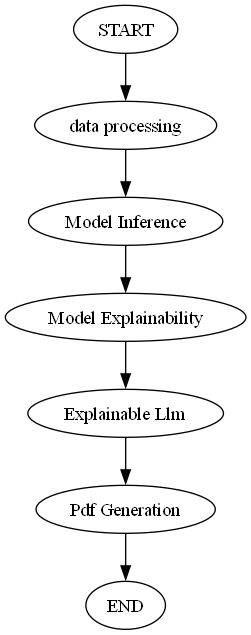

In [7]:
from graphviz import Digraph
from IPython.display import display, Image

# Create a directed graph
dot = Digraph(comment='Fraud Detection Pipeline', format='png')

# Global graph attributes to match your diagram style
dot.attr(rankdir='TB', size='6,10')
dot.attr('node', shape='ellipse', style='filled', fillcolor='white', color='black')

# Add nodes individually with proper shapes
dot.node("START", "START")
dot.node("data_processing", "data processing")
dot.node("model_inference", "Model Inference")
dot.node("model_explainability", "Model Explainability")
dot.node("explainable_llm", "Explainable Llm")
dot.node("pdf_generation", "Pdf Generation")
dot.node("END", "END")

# START gets a rounded rectangle (stadium shape) like in your diagram
dot.node("START", "START", shape="ellipse")

# Add edges
edges = [
    ("START", "data_processing"),
    ("data_processing", "model_inference"),
    ("model_inference", "model_explainability"),
    ("model_explainability", "explainable_llm"),
    ("explainable_llm", "pdf_generation"),
    ("pdf_generation", "END")
]

for src, dst in edges:
    dot.edge(src, dst)

# Render and display
dot.render('fraudrisk_pipeline', format='png', cleanup=True)
display(Image('fraudrisk_pipeline.png'))

### 7. Run Inference

In [8]:
# Pass the data into the state
final_state = app.invoke({"raw_data": inference_data})

# Access the final output from the LLM Analyst node
print(final_state["final_analysis"])

c:\Users\SolaiVenkatesanManog\projects\kaggle\fraud-detection\.venv\lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=FraudExplanation(investig...'Escalated for review')), input_type=FraudExplanation])
  return self.__pydantic_serializer__.to_python(


FraudExplanation(
    investigation_summary=InvestigationSummary(
        summary='The transaction under review involved a high-value clothing purchase using a bank transfer on a 
mobile device. The transaction amount is significantly above the historical median and upper quartile for similar 
transactions. The account age is notably lower than typical customer profiles, indicating recent account creation. 
However, the billing and shipping addresses match, and the quantity purchased is within the normal range. After 
weighing all observed factors, the transaction is classified as high risk due to the combination of unusually high 
transaction value and new account status.',
        risk_classification=<RiskLevel.HIGH: 'high'>
    ),
    transaction_identification=TransactionIdentification(
        transaction_id='cc928714-de9e-4abb-8409-102c75abb2ed',
        transaction_datetime='2024-03-09 09:56:04',
        customer_id='d0cbd989-590b-4605-b3ba-baf375e914e2'
    ),
    transaction_summary=TransactionSummary(
        transaction_amount=5465.95,
        product_category='clothing',
        quantity=2,
        payment_method='bank transfer',
        device_used='mobile',
        account_age_days=21,
        customer_age=29,
        billing_shipping_match=True,
        transaction_hour=4
    ),
    benchmark_comparisons=[
        BenchmarkComparison(
            metric='Transaction Amount',
            observed_value='5465.95',
            historical_typical_range='Median: 151.76, 25th-75th percentile: 68.61-296.05',
            assessment='The transaction amount of 5465.95 is substantially higher than the historical median 
(151.76) and exceeds the 75th percentile (296.05) for all transactions.'
        ),
        BenchmarkComparison(
            metric='Quantity',
            observed_value='2',
            historical_typical_range='Median: 3, 25th-75th percentile: 2-4',
            assessment='The quantity of 2 is within the typical historical range for transactions (2-4).'
        ),
        BenchmarkComparison(
            metric='Transaction Hour',
            observed_value='4',
            historical_typical_range='Median: 11, 25th-75th percentile: 5-17',
            assessment='The transaction occurred at 4:00, which is slightly below the 25th percentile (5) and 
earlier than the median transaction hour (11).'
        ),
        BenchmarkComparison(
            metric='Account Age',
            observed_value='21 days',
            historical_typical_range='Median: 179 days, 25th-75th percentile: 86-272 days',
            assessment='The account age of 21 days is significantly below the historical median (179 days) and 
falls below the 25th percentile (86 days).'
        )
    ],
    customer_account_context=CustomerAccountContext(
        account_tenure_assessment='The account was created 21 days prior to the transaction, which is considerably 
shorter than the typical customer account age observed in historical data.',
        customer_profile_assessment='The customer age and purchase behavior (quantity and product category) are 
within the expected range for the platform, but the account tenure is notably short.'
    ),
    feature_relationship_context=FeatureRelationshipContext(
        summary='The transaction combines a high-value clothing purchase with a bank transfer payment method on a 
mobile device from a newly created account. There is no strong historical correlation between these categorical 
features, but the combination of high transaction value and short account age is statistically notable.'
    ),
    legitimacy_signals=LegitimacySignals(
        signals=[
            'Billing and shipping addresses match',
            'Quantity purchased is within the typical range',
            'Product category (clothing) is common on the platform'
        ],
        assessment='The matching billing and shipping addresses and a typical purchase quantity provide evidence of
legitimate transaction behavior, partiall

In [9]:
# Pass the data into the state
final_state_no= app.invoke({"raw_data": inference_data_not_fraud})

# Access the final output from the LLM Analyst node
print(final_state_no["final_analysis"])

c:\Users\SolaiVenkatesanManog\projects\kaggle\fraud-detection\.venv\lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=FraudExplanation(investig...ction_taken='Approved')), input_type=FraudExplanation])
  return self.__pydantic_serializer__.to_python(


FraudExplanation(
    investigation_summary=InvestigationSummary(
        summary='The transaction under review involved the purchase of electronics using a credit card on a tablet 
device, with a transaction amount of $301.34 and a quantity of 3 items. The transaction occurred at midnight 
(00:53), which is outside the typical transaction hour range. The account has a tenure of 223 days, which is above 
the median for the customer base. The billing and shipping addresses match, and the transaction amount and quantity
are within the interquartile range of historical transactions. The overall risk posture is assessed as low, with 
the primary drivers being the alignment of transaction characteristics with historical norms and the presence of 
multiple legitimacy signals.',
        risk_classification=<RiskLevel.LOW: 'low'>
    ),
    transaction_identification=TransactionIdentification(
        transaction_id='7d187603-7961-4fce-9827-9698e2b6a201',
        transaction_datetime='2024-01-22 00:53:31',
        customer_id='4d158416-caae-4b09-bd5b-15235deb9129'
    ),
    transaction_summary=TransactionSummary(
        transaction_amount=301.34,
        product_category='electronics',
        quantity=3,
        payment_method='credit card',
        device_used='tablet',
        account_age_days=223,
        customer_age=35,
        billing_shipping_match=True,
        transaction_hour=0
    ),
    benchmark_comparisons=[
        BenchmarkComparison(
            metric='Transaction Amount',
            observed_value='301.34',
            historical_typical_range='68.61 - 296.05 (IQR), median 151.76',
            assessment='The transaction amount of $301.34 is slightly above the 75th percentile ($296.05) but 
remains within the overall historical range ($10.00 - $12,701.75).'
        ),
        BenchmarkComparison(
            metric='Quantity',
            observed_value='3',
            historical_typical_range='2 - 4 (IQR), median 3',
            assessment='The quantity of 3 matches the historical median and falls within the interquartile range (2
- 4).'
        ),
        BenchmarkComparison(
            metric='Transaction Hour',
            observed_value='0',
            historical_typical_range='5 - 17 (IQR), median 11',
            assessment='The transaction occurred at hour 0, which is below the 25th percentile (5) and outside the 
typical transaction hour range.'
        ),
        BenchmarkComparison(
            metric='Account Age',
            observed_value='223',
            historical_typical_range='86 - 272 days (IQR), median 179',
            assessment='The account age of 223 days is above the median and within the interquartile range for the 
customer base.'
        )
    ],
    customer_account_context=CustomerAccountContext(
        account_tenure_assessment='The account has been active for 223 days, which is above the median tenure of 
179 days and within the interquartile range (86 - 272 days), indicating established account history.',
        customer_profile_assessment='The customer age of 35 matches the historical median, and the use of a 
matching billing and shipping address is consistent with typical legitimate transactions.'
    ),
    feature_relationship_context=FeatureRelationshipContext(
        summary='The transaction combines a credit card payment, electronics product category, and tablet device 
usage. Historical data shows no significant correlation between these categorical features, and the combination is 
not statistically unusual. The matching billing and shipping addresses further align with patterns observed in 
legitimate transactions.'
    ),
    legitimacy_signals=LegitimacySignals(
        signals=[
            'Billing and shipping addresses match',
            'Account tenure is above median',
            'Quantity matches historical median',
            'Customer age matches historical median',
            'Payment method (credit card) is commonly used'
        ],
        as